# Script to view sensitivity analysis data from light calculations

Ideas:

- Heatmap
- Lollipop chart
- Taylor diagram
  - Replace traditional std with raw percent diff

Categorical factors to consider

- Model and scenario
- Dependent variable
- Setting turned off


In [32]:
import os
import glob
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import seaborn as sns
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.style.use("default")
import cartopy.crs as ccrs
import os

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

import geopandas as gpd
import rioxarray as rio
from shapely.geometry import mapping
from texttable import Texttable
import gcsfs
import geopandas as gpd
from CMIP6_IO import CMIP6_IO

<AxesSubplot:>

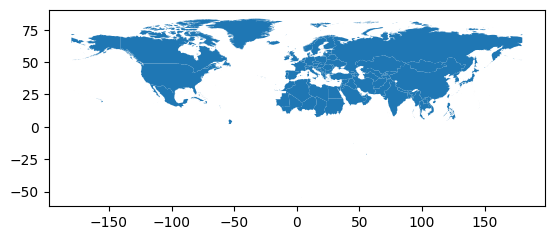

In [33]:
# read in world shapefile to clip data
world = gpd.read_file(
    "gs://actea-shared/Shapefiles/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp"
)
world = world.cx[:, 20:]
world.plot()

## Process Data


In [34]:
max_models = 1000
io = CMIP6_IO()
counter = 0
scenario = "ssp245"
lightpath = "light_sensitivity"
prefix = f"{lightpath}/{scenario}"
print(f"Finding files in bucket {prefix}")
files_on_gcs = []
for blob in io.bucket.list_blobs(prefix=prefix):
    counter += 1
    if "1979-01-01-1982" in blob.name and "srf" not in blob.name:
        files_on_gcs.append(blob.name)

# Variable names
file_names = [file.split("/")[-1].split("_")[0] for file in files_on_gcs]
var_names = np.unique(file_names)

# Remove ghi as we don not modify this variable at all with our settings
if "ghi" in var_names:
    var_names = np.delete(var_names, np.where(var_names == "ghi"))
if "uvi" in var_names:
    var_names = np.delete(var_names, np.where(var_names == "uvi"))

print(var_names)

# Model names
file_names = [file.split("/")[-1].split("_")[1] for file in files_on_gcs]
model_names = np.unique(file_names)
print(model_names)

# Factor names
factor_names = [
    "osa",
    "no_chl",
    "no_wind",
    "no_osa",
    "no_meltpond",
    "snow_sensitivity",
    "no_ice",
]
print(factor_names)

# Member IDS
file_names = [file.split("/")[-1].split("_")[2] for file in files_on_gcs]
file_names = [file for file in file_names if file.startswith("r")]
member_names = np.unique(file_names)

s = "_"
combined_names = []
for var_name in var_names:
    for model_name in model_names:
        for member_name in member_names:
            combined_names.append(s.join([var_name, model_name, member_name]))

print(combined_names)

print(
    f"Total number of files in bucket {counter} and unique variables {len(var_names)} and models {len(model_names)} and combined {len(combined_names)}"
)

Finding files in bucket light_sensitivity/ssp245
['osa' 'par' 'uv' 'uva' 'uvb']
['CanESM5' 'MPI-ESM1-2-HR' 'MPI-ESM1-2-LR' 'UKESM1-0-LL']
['osa', 'no_chl', 'no_wind', 'no_osa', 'no_meltpond', 'snow_sensitivity', 'no_ice']
['osa_CanESM5_r10i1p1f1', 'osa_CanESM5_r10i1p2f1', 'osa_CanESM5_r1i1p1f1', 'osa_CanESM5_r1i1p1f2', 'osa_CanESM5_r2i1p1f1', 'osa_CanESM5_r2i1p1f2', 'osa_CanESM5_r2i1p2f1', 'osa_CanESM5_r3i1p1f2', 'osa_CanESM5_r3i1p2f1', 'osa_CanESM5_r4i1p1f1', 'osa_CanESM5_r4i1p1f2', 'osa_CanESM5_r5i1p1f1', 'osa_CanESM5_r6i1p1f1', 'osa_CanESM5_r7i1p2f1', 'osa_CanESM5_r9i1p2f1', 'osa_MPI-ESM1-2-HR_r10i1p1f1', 'osa_MPI-ESM1-2-HR_r10i1p2f1', 'osa_MPI-ESM1-2-HR_r1i1p1f1', 'osa_MPI-ESM1-2-HR_r1i1p1f2', 'osa_MPI-ESM1-2-HR_r2i1p1f1', 'osa_MPI-ESM1-2-HR_r2i1p1f2', 'osa_MPI-ESM1-2-HR_r2i1p2f1', 'osa_MPI-ESM1-2-HR_r3i1p1f2', 'osa_MPI-ESM1-2-HR_r3i1p2f1', 'osa_MPI-ESM1-2-HR_r4i1p1f1', 'osa_MPI-ESM1-2-HR_r4i1p1f2', 'osa_MPI-ESM1-2-HR_r5i1p1f1', 'osa_MPI-ESM1-2-HR_r6i1p1f1', 'osa_MPI-ESM1-2-HR_r7i1

In [35]:
def create_map_of_differences(osa, factor, name):
    lev = np.arange(0.01, 1, 0.05)
    cm = level_colormap(lev, cmap=plt.cm.get_cmap("RdBu_r"))
    units = "diff"

    lev_diff = np.arange(-0.01, 0.01, 0.001)
    cm_diff = level_colormap(lev, cmap=plt.cm.get_cmap("RdBu_r"))

    fig = plt.figure(figsize=(12, 12))

    projection = ccrs.NorthPolarStereo()
    axes_class = (GeoAxes, dict(map_projection=projection))
    grids = AxesGrid(
        fig,
        111,
        axes_class=axes_class,
        nrows_ncols=(3, 1),
        axes_pad=(
            0.6,
            0.5,
        ),  # control padding separately for e.g. colorbar labels, axes titles, etc.
        cbar_location="bottom",
        cbar_mode="single",
        cbar_pad="5%",
        cbar_size="5%",
        label_mode="",
    )

    ds_all = [osa, factor, osa - factor]
    for i, grid_ax in enumerate(grids):
        ds = ds_all[i]
        # Get the regional domain to plot for the climatology plots and make sure that
        # we dont use too frequent ticks depending on the size of the region
        grid_ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        grid_ax.set_aspect(0.7)

        if i == 2:
            cm = cm_diff
            lev = lev_diff

        cs = grid_ax.contourf(
            ds.lon,
            ds.lat,
            ds[:, :],
            levels=lev,
            # locator=loc_ticker,
            cmap=cm,
            zorder=2,
            alpha=1.0,
            extend="both",
            transform=ccrs.PlateCarree(),
        )

        # contour lines
        #   grid_ax.contour(ds.lon,
        #                   ds.lat,
        #                   ds[:,:], colors='k',
        #                   levels=lev, linewidths=0.1,
        #                   transform=ccrs.PlateCarree())

        grid_ax.set_title(name)
        grid_ax.add_feature(cfeature.LAND, color="grey", zorder=3)
        grid_ax.coastlines(
            resolution="110m", linewidth=0.2, color="black", alpha=1.0, zorder=4
        )

    cb = grids.cbar_axes[0].colorbar(cs, format="%.1f", label=units)

    # if not os.path.exists(baseURL_output):
    #     os.makedirs(baseURL_output)

    #  plotfile = "{}/{}_{}_clim.png".format(baseURL_output, prefix, varname)
    #  print("[CMIP6_plot] Created plot {} ".format(plotfile))
    #  plt.savefig(plotfile, dpi=200, facecolor='w', transparent=False, bbox_inches='tight')
    plt.show()


def level_colormap(levels, cmap=None):
    """Make a colormap based on an increasing sequence of levels"""

    # Spread the colours maximally
    nlev = len(levels)
    S = np.arange(nlev, dtype="float") / (nlev - 1)
    A = cmap(S)

    # Normalize the levels to interval [0,1]
    levels = np.array(levels, dtype="float")
    L = (levels - levels[0]) / (levels[-1] - levels[0])

    # Make the colour dictionary
    R = [(L[i], A[i, 0], A[i, 0]) for i in range(nlev)]
    G = [(L[i], A[i, 1], A[i, 1]) for i in range(nlev)]
    B = [(L[i], A[i, 2], A[i, 2]) for i in range(nlev)]
    cdict = dict(red=tuple(R), green=tuple(G), blue=tuple(B))

    # Use
    return colors.LinearSegmentedColormap("%s_levels" % cmap.name, cdict, 256)

In [36]:
save_to_csv = True
counter = 0
data_final = pd.DataFrame()

if save_to_csv:
    # Loop over all files and filter on the models defined in source_ids.
    for model_var in combined_names:
        data = xr.Dataset()

        # loop through each file
        for file in files_on_gcs:
            # print(file)
            # if it's a file of the current model parameter
            # print(f"Inside trying file {file} testing {model_var}_", f'{model_var}_' in file)
            if f"{model_var}_" in file:
                temp = io.open_dataset_on_gs(file).astype("float32")
                temp.close()

                # rename the variable to be the certain model run
                for var in temp.data_vars:
                    print(
                        f"Renaming variable from {var} to {model_var+'_'+ file.split('/')[-1].split('scenario_')[-1].split('_ssp')[0]}"
                    )
                    temp = temp.rename(
                        {
                            var: model_var
                            + "_"
                            + file.split("/")[-1]
                            .split("scenario_")[-1]
                            .split("_ssp")[0]
                        }
                    )
                # join together
                data = xr.merge([data, temp])

        if data:
            # calculate the percent difference

            # convert longitude to ±180
            data.coords["lon"] = (data.coords["lon"] + 180) % 360 - 180
            data = data.sortby(data.lon)

            # clip the netcdf data from land
            data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
            data.rio.write_crs("epsg:4326", inplace=True)

            # clip the data
            data_clipped = data.rio.clip(
                world.geometry.apply(mapping), world.crs, drop=True
            )
            data_clipped["mask"] = xr.where(
                np.isnan(data_clipped[model_var + "_osa"]), 1, np.nan
            )

            data = data * data_clipped["mask"]
            data = data.astype("float32")

            data = data.mean("time", skipna=True)

            #   create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_meltpond'], "No meltponds")
            #   create_map_of_differences(data[model_var + '_osa'], data[model_var + '_snow_sensitivity'], "Snow sens")
            #   create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_chl'], "No chl")
            #   create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_osa'], "No OSA")
            #   create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_wind'], "No wind")

            to_percent_or_fraction = 100

            minus_meltpond_numinator = (
                data[model_var + "_no_meltpond"] - data[model_var + "_osa"]
            )
            minus_meltpond_denominator = np.nanmax(
                (data[model_var + "_no_meltpond"], data[model_var + "_osa"])
            )
            minus_meltpond = (
                minus_meltpond_numinator / np.abs(minus_meltpond_denominator)
            ) * to_percent_or_fraction

            minus_ice_numinator = data[model_var + "_no_ice"] - data[model_var + "_osa"]
            minus_ice_denominator = np.nanmax(
                (data[model_var + "_no_ice"], data[model_var + "_osa"])
            )
            minus_ice = (
                minus_ice_numinator / np.abs(minus_ice_denominator)
            ) * to_percent_or_fraction

            minus_snow_sens_numinator = (
                data[model_var + "_snow_sensitivity"] - data[model_var + "_osa"]
            )
            minus_snow_sens_denominator = np.nanmax(
                (data[model_var + "_snow_sensitivity"], data[model_var + "_osa"])
            )
            minus_snow_sens = (
                minus_snow_sens_numinator / np.abs(minus_snow_sens_denominator)
            ) * to_percent_or_fraction

            minus_osa_numinator = data[model_var + "_no_osa"] - data[model_var + "_osa"]
            minus_osa_denominator = np.nanmax(
                (data[model_var + "_no_osa"], data[model_var + "_osa"])
            )
            minus_osa = (
                minus_osa_numinator / np.abs(minus_osa_denominator)
            ) * to_percent_or_fraction

            minus_chl_numinator = data[model_var + "_no_chl"] - data[model_var + "_osa"]
            minus_chl_denominator = np.nanmax(
                (data[model_var + "_no_chl"], data[model_var + "_osa"])
            )
            minus_chl = (
                minus_chl_numinator / np.abs(minus_chl_denominator)
            ) * to_percent_or_fraction

            minus_wind_numinator = (
                data[model_var + "_no_wind"] - data[model_var + "_osa"]
            )
            minus_wind_denominator = np.nanmax(
                (data[model_var + "_no_wind"], data[model_var + "_osa"])
            )
            minus_wind = (
                minus_wind_numinator / np.abs(minus_wind_denominator)
            ) * to_percent_or_fraction

            data = data.assign(
                minus_ice=minus_ice,
                minus_snow_sens=minus_snow_sens,
                minus_meltpond=minus_meltpond,
                minus_osa=minus_osa,
                minus_chl=minus_chl,
                minus_wind=minus_wind,
            )

            #   data_df = data.to_dataframe().reset_index().T.drop('time', axis = 0).reset_index().rename({'index':'variable', 0:'diff'}, axis = 1)
            data_df = (
                data.to_dataframe()
                .reset_index()
                .T.reset_index()
                .rename({"index": "variable"}, axis=1)
            )
            data_df["diff"] = data_df.iloc[:, 1:8641].mean(axis=1)
            data_df.drop(data_df.iloc[:, 1:8641], inplace=True, axis=1)

            data_df["model_combined"] = model_var
            data_df["model"] = model_var.split("_")[1]
            data_df["member_id"] = model_var.split("_")[2]
            data_df["factor"] = model_var.split("_")[0]

            data_df = data_df[data_df["variable"].str.contains("minus")]

            #     #function to calculate correlation
            #     def calc_corr(variable):

            #         from scipy.stats import pearsonr

            #         data_corr = data[[var + '_no_' + variable, var + '_osa']].to_dataframe().dropna()
            #         return float(pearsonr(data_corr[var + '_no_' + variable], data_corr[var + '_osa'])[0])

            #     r = [calc_corr('wind'), calc_corr('osa'), calc_corr('ice'), calc_corr('chl')]
            #     s = [float(data['minus_wind'].std()), float(data['minus_osa'].std()), float(data['minus_ice'].std()), float(data['minus_chl'].std())]
            #     data_df = pd.DataFrame({'Variable':var, 'Setting':['no_wind', 'no_osa', 'no_ice', 'no_chl'], 'Corr':r, 'Std':s})
            # join models together
            data_final = pd.concat([data_final, data_df])

    # save data
    data_final.to_csv("per_diff_scenario_ssp245_1979_1989.csv", index=False)

[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1982-12-16_scenario_no_chl_ssp245.nc
Renaming variable from osa to osa_CanESM5_r10i1p2f1_no_chl
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1982-12-16_scenario_no_ice_ssp245.nc
Renaming variable from osa to osa_CanESM5_r10i1p2f1_no_ice
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1982-12-16_scenario_no_meltpond_ssp245.nc
Renaming variable from osa to osa_CanESM5_r10i1p2f1_no_meltpond
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1982-12-16_scenario_no_osa_ssp245.nc
Renaming variable from osa to osa_CanESM5_r10i1p2f1_no_osa
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1982-12-16_scenario_no_wind_ssp245.nc
Renaming variable from osa to osa_CanESM5_r10i1p2f1_no_wind
[CMIP6_IO] Opening file actea-sha

In [37]:
df = pd.read_csv("per_diff_scenario_ssp245_1979_1989.csv")
df.head(50)

,variable,diff,model_combined,model,member_id,factor
0,minus_ice,-68.673767,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
1,minus_snow_sens,0.000000,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
2,minus_meltpond,0.416111,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
3,minus_osa,0.104511,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
4,minus_chl,0.000935,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
5,minus_wind,0.005640,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
6,minus_ice,-66.797377,osa_CanESM5_r2i1p2f1,CanESM5,r2i1p2f1,osa
7,minus_snow_sens,0.000000,osa_CanESM5_r2i1p2f1,CanESM5,r2i1p2f1,osa
8,minus_meltpond,0.356170,osa_CanESM5_r2i1p2f1,CanESM5,r2i1p2f1,osa
9,minus_osa,0.118382,osa_CanESM5_r2i1p2f1,CanESM5,r2i1p2f1,osa


## Lollipop Chart


['minus_chl' 'minus_ice' 'minus_meltpond' 'minus_osa' 'minus_snow_sens'
 'minus_wind']
var minus_chl
var minus_ice
var minus_meltpond
var minus_osa
var minus_snow_sens
var minus_wind


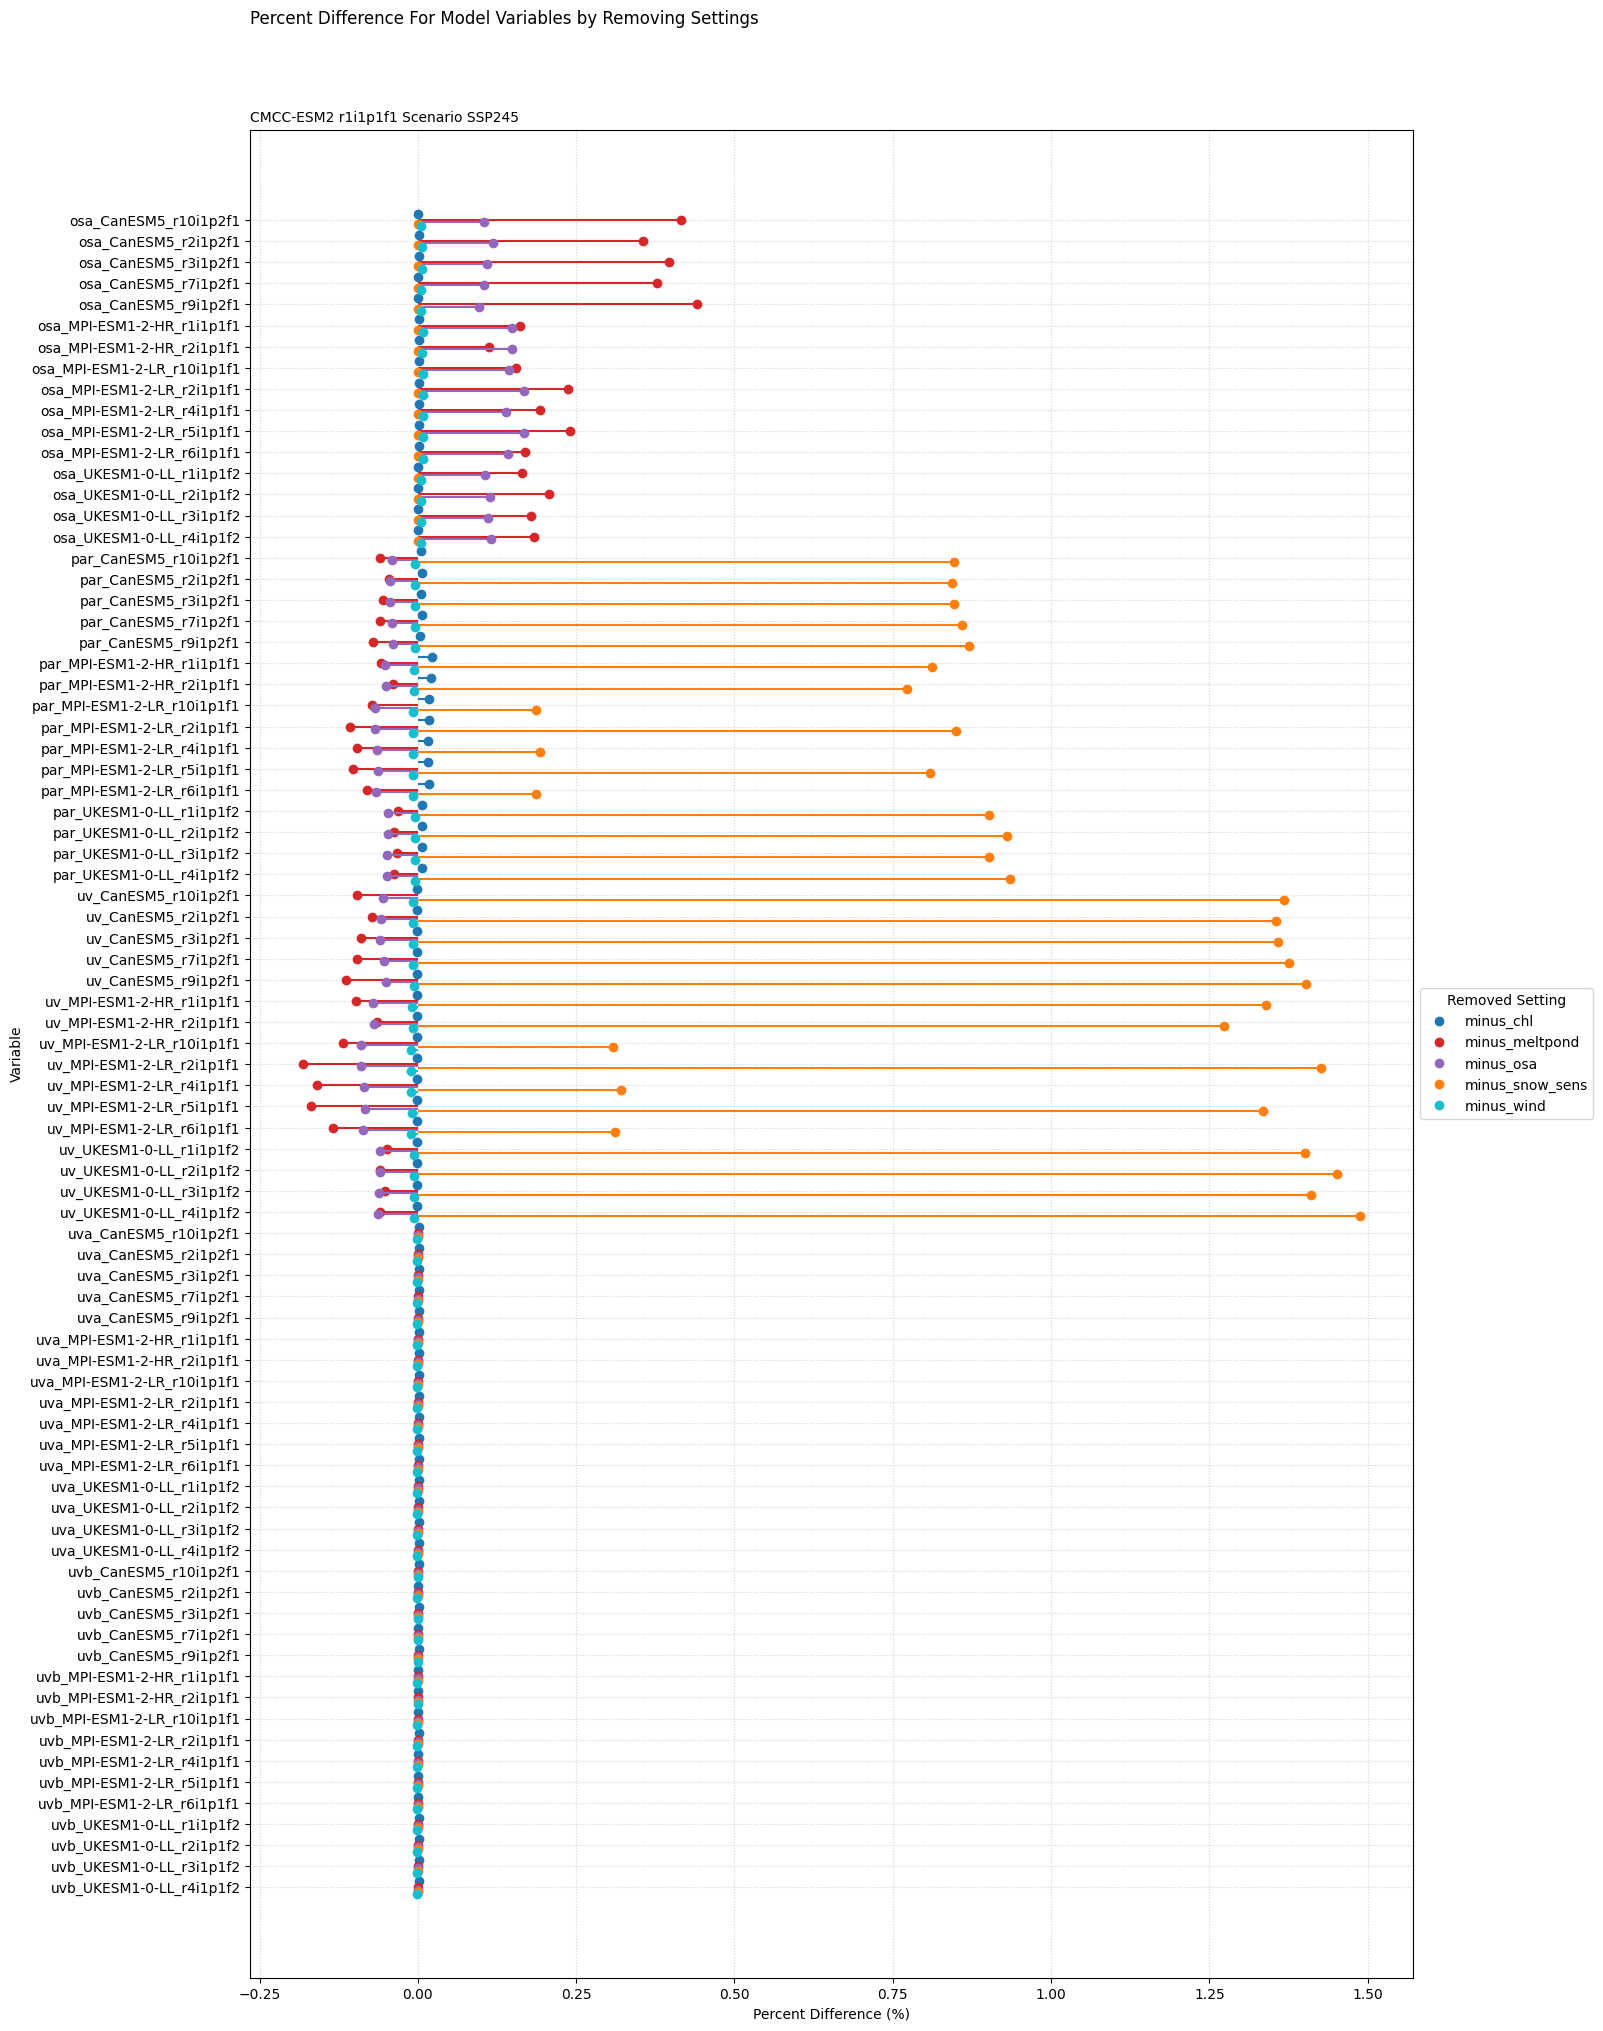

In [38]:
# define figure
import pandas as pd
import matplotlib as mpl

mpl.rcParams["figure.facecolor"] = "white"
data_final = pd.read_csv("per_diff_scenario_ssp245_1979_1989.csv")
fig, ax = plt.subplots(1, 1, figsize=(15, 24))
print(np.unique(data_final["variable"]))
# ['no_ice', 'no_chl', 'no_wind', 'no_osa', 'no_meltpond', 'snow_sensitivity']
# ["no_ice", "no_chl", "no_wind", "no_osa", "no_meltpond", "snow_sensitivity"]
# loop through the four removed settings (each loop will have an offset for the graph, the removed setting to subset the data, and a color for the graph)
for i, var, col in zip(
    [-0.3, -0.2, 0.0, 0.1, 0.2, 0.3],
    np.unique(data_final["variable"]),
    [
        "tab:blue",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:orange",
        "tab:cyan",
        "magenta",
    ],
):
    # subset the data for only the removed variable
    data_temp = data_final[data_final["variable"] == var]
    print("var", var)
    if var not in ["minus_ice"]:
        # create a range based on the length of data and add the offset
        my_range = range(1, len(data_temp.index) + 1)
        my_range = [j + i for j in my_range]

        # the horizontal plot is made using the hline function and the plot function
        ax.hlines(y=my_range, xmin=0, xmax=data_temp["diff"], color=col)
        ax.plot(data_temp["diff"], my_range, "o", color=col, label=var)

# add titles and axis names
ax.set_yticks(
    range(1, len(np.unique(data_final["model_combined"])) + 1),
    data_temp["model_combined"],
)
fig.suptitle(
    "Percent Difference For Model Variables by Removing Settings",
    horizontalalignment="left",
    x=0.125,
    y=0.93,
)
ax.set_title("CMCC-ESM2 r1i1p1f1 Scenario SSP245", loc="left", fontsize=10)
ax.set_xlabel("Percent Difference (%)")
ax.set_ylabel("Variable")

# add gridlines and legend
ax.grid(linestyle="dotted", color="lightgrey", zorder=0)
L = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Removed Setting")

# rename legend values
# for i, label in enumerate(data_temp['model_combined']):
#    print(label)
#    L.get_texts()[i].set_text(label)

# Show the plot
ax.invert_yaxis()
plt.show()

## Heatmap


In [39]:
y_axis_labels = ["Chl", "OSA", "Wind", "Snow"]  # labels for y-axis

data_final = data_final[data_final["variable"] != "minus_ice"]
# convert the data to a float
data_final["diff"] = data_final["diff"].astype(float)
# convert the data from wide to long
data_heatmap = data_final.pivot(index="variable", columns="model", values="diff")
# create a seaborn heatmap
sns.heatmap(
    data_heatmap,
    annot=False,
    fmt=".2f",
    vmin=0,
    cmap="viridis",
    yticklabels=y_axis_labels,
    cbar_kws={"pad": 0.03, "label": "Percent (%)"},
)

# add and format axis labels and title
plt.xlabel("Variable")
plt.ylabel("Removed Setting")
plt.yticks(rotation=0)
plt.title("Percent Difference For Model \nVariables by Removing Settings")
# plt.savefig('/Users/administrator/Downloads/Trond Data/Trond_SensitivityAnalysis_HeatMap.png', dpi = 300)

ValueError: Index contains duplicate entries, cannot reshape

## Summarized Heatmap (Fit more Models)


In [ ]:
# create some dummy data
data_full = pd.DataFrame()
for i in range(20):
    data_temp = data_final.copy()
    data_temp = data_temp.rename({"variable": "removed_setting"}, axis=1)
    data_temp = data_temp.rename({"model": "variable"}, axis=1)
    data_temp["diff"] = data_temp["diff"] + np.random.random()
    data_temp["model"] = "Model_" + str(i)
    data_full = pd.concat([data_temp, data_full])

# summarize data by model run and variable
data_full = (
    data_full.drop("removed_setting", axis=1)
    .groupby(["model", "variable"])
    .agg(["mean", "std"])
    .droplevel(0, axis=1)
    .reset_index()
)

# custom y_axis_labels if you want them
y_axis_labels = ["Chl", "Ice", "OSA", "Wind"]  # labels for y-axis

# define axis labels
data_full["labels"] = (
    np.round(data_full["mean"], 2).astype(str)
    + " ± "
    + np.round(data_full["std"], 2).astype(str)
)
labels = data_full.pivot(index="model", columns="variable", values="labels").to_numpy()


plt.figure(figsize=(20, 12))
# convert data from wide to long
data_heatmap = data_full.drop("std", axis=1).pivot(
    index="model", columns="variable", values="mean"
)
# visualize data in seaborn heatmap
sns.heatmap(
    data_heatmap,
    annot=labels,
    fmt="",
    vmin=0,
    cmap="viridis",
    cbar_kws={"pad": 0.02, "label": "Mean Percent ± std"},
)  # yticklabels=y_axis_labels)

# define axis labels and title
plt.xlabel("Variable")
plt.ylabel("Model Run")
plt.yticks(rotation=0)
plt.title("Percent Difference For Model Variables by Different Models (ssp 245)")
plt.savefig("Trond_SensitivityAnalysis_SummarizedHeatmap.png", dpi=300)

## Taylor Diagram

Code modified from: https://stackoverflow.com/questions/67907069/label-taylor-diagram-with-number-by-python


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
    def __init__(self, STD, fig=None, rect=111, label="_"):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs)  # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs)  # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.6 * self.STD
        gh = fa.GridHelperCurveLinear(
            tr,
            extremes=(0, (np.pi / 2), self.smin, self.smax),
            grid_locator1=gl1,
            tick_formatter1=tf1,
        )
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.axis["top"].set_axis_direction("bottom")
        ax.axis["top"].label.set_text("Correlation coefficient")
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        # X axis
        ax.axis["left"].set_axis_direction("bottom")
        ax.axis["left"].label.set_text("Standard deviation")
        ax.axis["left"].toggle(ticklabels=True, label=True)
        ax.axis["left"].major_ticklabels.set_axis_direction("bottom")
        ax.axis["left"].label.set_axis_direction("bottom")
        # Y axis
        ax.axis["right"].set_axis_direction("top")
        ax.axis["right"].label.set_text("Standard deviation")
        ax.axis["right"].toggle(ticklabels=True, label=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")
        ax.axis["right"].label.set_axis_direction("top")
        # Useless
        ax.axis["bottom"].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax  # Graphical axes
        self.ax = ax.get_aux_axes(tr)  # Polar coordinates
        # Add reference point and STD contour
        (l,) = self.ax.plot([0], self.STD, "k*", ls="", ms=12, label=label)
        (l1,) = self.ax.plot([0], self.STD, "k*", ls="", ms=12, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        t1 = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        r1 = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, "k--", label="_")
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
        self.samplePoints = [l1]

    def add_sample(self, STD, r, *args, **kwargs):
        (l,) = self.ax.plot(np.arccos(r), STD, *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_sample(self, STD, r1, *args, **kwargs):
        (l1,) = self.ax.plot(np.arccos(r1), STD, *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l1)
        return l1

    def add_contours(self, levels=5, **kwargs):
        rs, ts = np.meshgrid(
            np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0))
        )
        RMSE = np.sqrt(
            np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs * np.cos(ts))
        )
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours


def srl(obsSTD, s, s1, r, r1, l, l1, m, m1, fname):
    fig = plt.figure(figsize=(8, 8))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label="ref")
    plt.clabel(dia.add_contours(colors="#808080"), inline=1, fontsize=10)

    for mark, j, setting in zip(["o", "^", "s", "h"], range(9), np.unique(m)):
        s = s_full.iloc[0 + (j * 4) : 4 + (j * 4)]
        r = r_full.iloc[0 + (j * 4) : 4 + (j * 4)]
        l = l_full.iloc[0 + (j * 4) : 4 + (j * 4)]
        m = m_full.iloc[0 + (j * 4) : 4 + (j * 4)]

        srlc = zip(s, r, l, m)
        srlc1 = zip(s1, r1, l1, m1)

        for i, col in zip(
            srlc,
            [
                "#e41a1c",
                "#377eb8",
                "#4daf4a",
                "#984ea3",
                "#ff7f00",
                "#ffff33",
                "#a65628",
                "#f781bf",
                "#999999",
            ],
        ):
            dia.add_sample(
                i[0],
                i[1],
                label=i[2] + "-" + i[3],
                marker=mark,
                markersize=10,
                mec=col,
                mfc="none",
                mew=1.6,
            )

    #     for i in srlc1:
    #         dia.add_sample(i[0], i[1], label=i[2], marker='^', mec = 'blue', mfc = 'none', mew=1.6)

    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(
        dia.samplePoints, spl, numpoints=1, prop=dict(size="small"), loc=[0.82, 0.5]
    )
    fig.gca().set_aspect("equal")
    plt.show()


obsSTD = 6

# s = [1.275412605,1.391302157,1.424314937]
# s1 = [0.980035327,0.997244197, 1.003002031]
# r = [0.572272,0.533529,0.477572]
# r1 = [0.82,0.72,0.8]

# l = ['A', 'B', 'C']
# l1 = ['A', 'B', 'C']

s_full = data_final["Std"]
r_full = data_final["Corr"]
l_full = data_final["Variable"]
m_full = data_final["Setting"]

fname = "TaylorDiagram.jpg"
srl(obsSTD, s_full, s1, r_full, r1, l_full, l1, m_full, m1, fname)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define the function to be plotted
def ice_thickness_function(ice_thickness, fhtan):
    return np.where(
        (np.arctan(ice_thickness * 4.0) / fhtan) >= 1.0,
        1.0,
        np.arctan(ice_thickness * 4.0) / fhtan,
    )


ahmax = 0.5

# Calculate fhtan
fhtan = np.arctan(ahmax * 4.0)

# Generate 1000 points between 0 and 1 for ice_thickness
ice_thickness_values = np.linspace(0, 1, 1000)

# Compute the function values
function_values = ice_thickness_function(ice_thickness_values, fhtan)

# Plot using Seaborn
sns.set()  # Apply the default Seaborn theme, scaling, and color palette
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=ice_thickness_values, y=function_values)  # Create the line plot
plt.title("Plot of the ice_thickness function")  # Set the title of the plot
plt.xlabel("Ice Thickness")  # Set the x-axis label
plt.ylabel("Function Value")  # Set the y-axis label
plt.show()  # Display the plot